<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: Data Scientist в Segmento Екатерина Демидова

# <center>Домашнее задание 2. <br> Визуальный анализ данных о публикациях на Хабрахабре</center>

In [1]:
# отключим предупреждения Anaconda

import warnings
warnings.simplefilter('ignore')

import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# будем отображать графики прямо в jupyter'e
%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go



init_notebook_mode(connected=True)

Populating the interactive namespace from numpy and matplotlib


## Загрузка и знакомство с данными

Для работы вам понадобятся данные из нашего учебного конкурса на kaggle [«Прогноз популярности статьи на Хабре»](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). Файл **`howpop_train.csv`** уже лежит в нашем репозитории в каталоге **`data`**, но его можно скачать и с Kaggle.

In [2]:
df = pd.read_csv('../../data/howpop_train.csv')

In [3]:
df.shape

(134137, 17)

In [4]:
df.head(3).T

,0,1,2
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00
author,@Tapac,@DezmASter,@DezmASter
flow,develop,design,design
polling,False,False,False
content_len,4305,7344,8431
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ..."
comments,0,1,47


Избавимся сразу от переменных, названия которых заканчиваются на `_lognorm` (нужны для соревнования на Kaggle). Выберем их с помощью `filter()` и удалим `drop`-ом:

In [5]:
df.drop(filter(lambda c: c.endswith('_lognorm'), df.columns), 
        axis = 1,       # axis = 1: столбцы 
        inplace = True) # избавляет от необходимости сохранять датасет

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.0,115565.0,182666.0,257401.0,314088.0
content_len,134137.0,7516.929699,8724.771640,1.0,2179.0,4949.0,9858.0,352471.0
comments,134137.0,39.625994,62.398958,0.0,7.0,19.0,48.0,2266.0
favs,134137.0,71.999866,145.854135,0.0,8.0,27.0,78.0,8718.0
views,134137.0,16631.013084,31479.819691,3.0,2100.0,7600.0,18700.0,1730000.0
votes_plus,133566.0,35.536888,42.461073,0.0,11.0,22.0,45.0,1466.0
votes_minus,133566.0,8.050035,11.398282,0.0,2.0,5.0,10.0,445.0


In [7]:
df.describe(include = ['object', 'bool'] # бинарные и категориальные переменные
           ).T

,count,unique,top,freq
url,134137,134137,https://geektimes.ru/post/93323/,1
domain,134137,2,habrahabr.ru,97048
published,134137,130291,2011-06-14 15:52:00,39
author,97657,22077,@alizar,5292
flow,97048,6,develop,53318
polling,134137,2,False,129412
title,134137,133628,"Интересные события, произошедшие в выходные",56


In [8]:
# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

Столбец **`published`** (время публикации) содержит строки. Чтобы мы могли работать с этими данными как с датой/временем публикации, приведём их к типу `datetime`:

In [9]:
print(df.published.dtype)
df['published'] = pd.to_datetime(df.published, yearfirst = True)
print(df.published.dtype)

object
datetime64[ns]


Создадим несколько столбцов на основе данных о времени публикации:

In [10]:
df['year'] = [d.year for d in df.published]
df['month'] = [d.month for d in df.published]

df['dayofweek'] = [d.isoweekday() for d in df.published]
df['hour'] = [d.hour for d in df.published]

-----
Теперь Ваша очередь. В каждом пункте предлагается построить картинку и с ее помощью ответить на вопрос в [форме](https://docs.google.com/forms/d/e/1FAIpQLSf3b5OG8zX_nLQBQ-t20c6M5Auz-VUL-yxj8Fm9_o_XWDBTrg/viewform?c=0&w=1). Конечно, можно попытаться ответить на все вопросы только с Pandas, без картинок, но мы советуем Вам потренироваться строить (красивые) визуализации.   

## 1\. В каком месяце (и какого года) было больше всего публикаций?

* март 2016,
* март 2015,
* апрель 2015,
* апрель 2016.

In [11]:
df['year_month'] = [d.strftime("%B %Y")  for d in df.published]

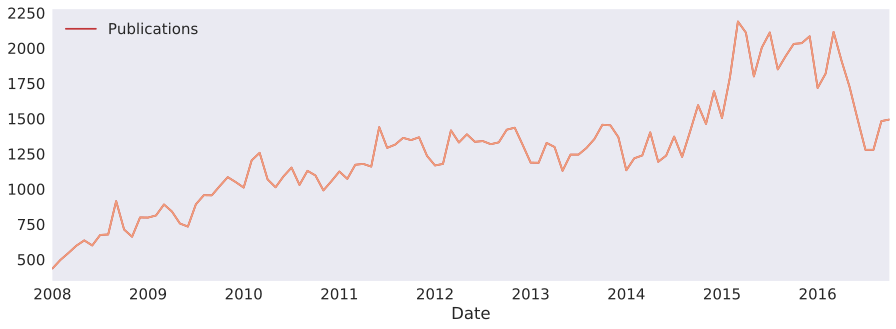

In [12]:
ym = df.sort_values('published')[['year_month']+['published']];
#ym.groupby('year_month').sum().plot(kind='bar');
#ym.sort(['published']).groupby('year_month').sum().head(10)
#ym.groupby(ym['year_month']).count().plot(kind="bar")

#ym.published.groupby([df.published.dt.year, df.published.dt.month]).count().plot(kind="bar")

ax = ym.groupby([ym['published'].dt.to_period('M')]).count().plot()
ax.set_xlabel('Date')
ax.legend(["Publications"])

In [13]:

ym_df =  ym.groupby([ym['published'].dt.to_period('M')])[['year_month']].count()
#ym_df
# ym_df['ym'] = ym_df.index
#years_df.columns = ['Publications', 'Number_of_Games']

trace0 = go.Scatter(
     x=ym_df.index.strftime('%Y-%m'),
    y=ym_df.year_month,
    name='Publications'
)

# print(ym_df.index.strftime('%Y-%m'))

data = [trace0]
layout = {'title': 'Statistics of publications'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)
      
# март 2015 - 2189

## 2\. Проанализируйте публикации в этом месяце (из вопроса 1)

Выберите один или несколько вариантов:

* На графике не заметны какие-либо выбросы или аномалии,
* Один или несколько дней сильно выделяются из общей картины,
* На хабре _всегда_ больше статей, чем на гиктаймсе,
* По субботам на гиктаймс и на хабрахабр публикуют примерно одинаковое число статей.

Подсказки: постройте график зависимости числа публикаций от дня; используйте параметр `hue`

In [14]:
march_df =  df[(df.year == 2015) & (df.month == 3)]
march_df
march_day_df =  march_df.groupby([march_df['published'].dt.to_period('D')])[['dayofweek']].count()
#ym_df
# ym_df['ym'] = ym_df.index
#years_df.columns = ['Publications', 'Number_of_Games']

trace0 = go.Scatter(
     x=march_day_df.index.strftime('%D'),
    y=march_day_df.dayofweek,
    name='Publications'
)


data = [trace0]
layout = {'title': 'Statistics of publications'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

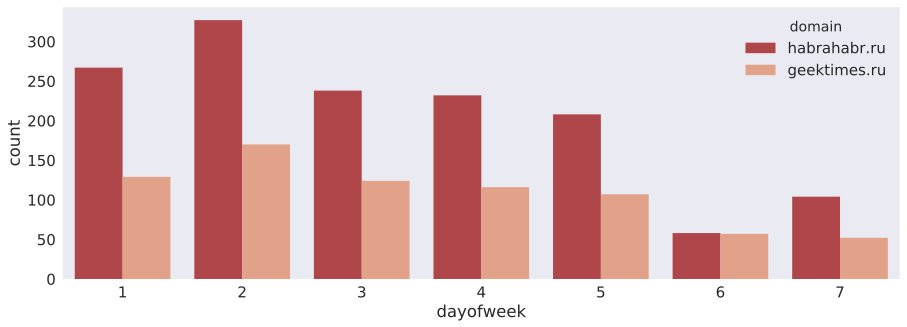

In [15]:
sns.countplot(x='dayofweek', hue='domain', data=march_df);

## 3\. Выберите верное утверждение

* Больше всего просмотров (в среднем) набирают статьи, опубликованные в 12 часов дня;
* У опубликованных в 10 утра постов больше всего комментариев  (в среднем);
* Больше всего просмотров  (в среднем) набирают статьи, опубликованные в 6 часов утра;
* Максимальное число комментариев на гиктаймсе набрала статья, опубликованная в 9 часов вечера;
* На хабре дневные статьи комментируют чаще  (в среднем), чем вечерние.

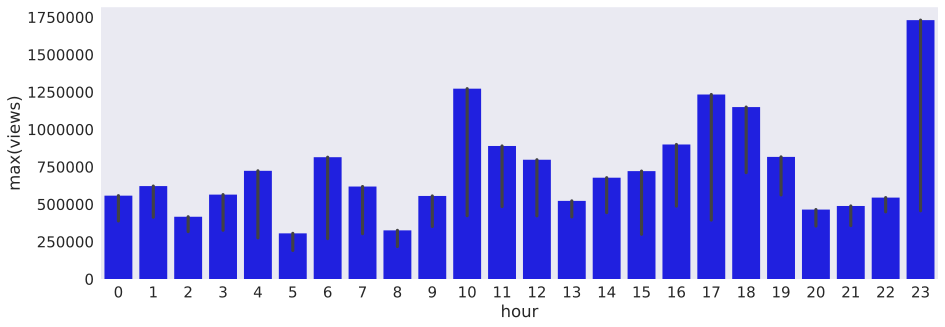

In [16]:
# sns.countplot(x='hour', hue='hour', data=march_df);
# # создаем Box trace для каждого часа из наших данных
# data = []
# for hour in df.hour.unique():
#     data.append(
#         go.Box(y=df[df.hour==hour].views, name=hour)
#     )

# # визуализируем данные
# iplot(data, show_link = False)
sns.barplot(x="hour", y="views", data=df,
            label="All Views", color="b",estimator=max);


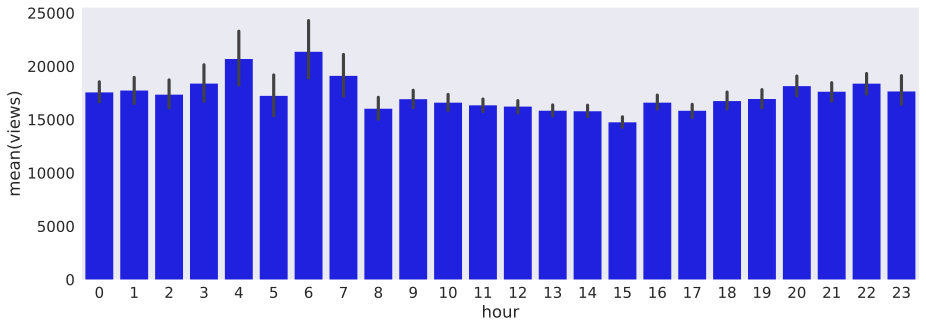

In [17]:
sns.barplot(x="hour", y="views", data=df,
            label="All Views", color="b");

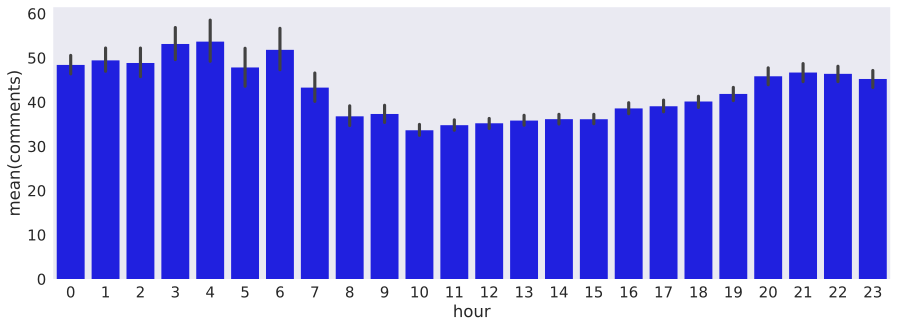

In [18]:
sns.barplot(x="hour", y="comments", data=df,
            label="All Views", color="b");

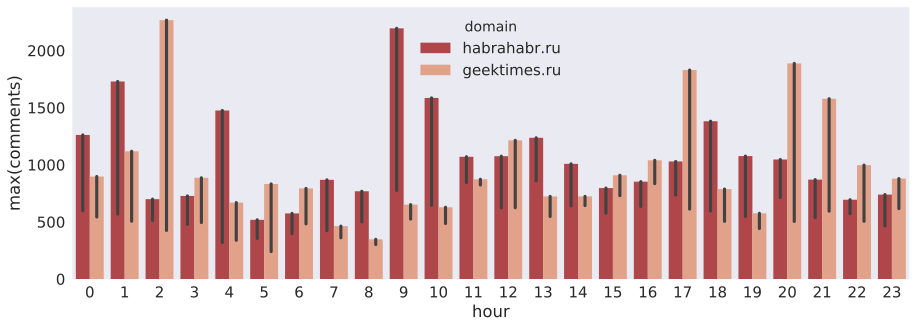

In [19]:
sns.barplot(x="hour", y="comments", hue='domain',data=df, estimator=max);

In [20]:
df.groupby('hour').median().sort_values('views',ascending=False)

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,year,month,dayofweek
hour,,,,,,,,,,,
6,171098.0,False,6467.0,28.0,34.0,8850.0,28.5,5.0,2013.0,6.0,3.0
9,213439.0,False,6656.0,17.0,32.0,8300.0,20.0,4.0,2014.0,7.0,3.0
11,212811.0,False,5806.0,16.0,29.0,8100.0,19.0,4.0,2013.0,7.0,3.0
21,164342.0,False,4188.5,24.0,26.0,8000.0,26.0,5.0,2012.0,6.0,4.0
10,220654.0,False,6343.0,15.0,30.0,8000.0,18.0,4.0,2014.0,7.0,3.0
20,167537.0,False,4201.0,24.0,26.0,7900.0,26.0,5.0,2012.0,6.0,3.0
7,180820.0,False,5857.5,23.0,35.5,7850.0,25.0,5.0,2013.0,6.0,3.0
22,164581.0,False,4183.0,25.0,27.0,7800.0,27.0,5.0,2012.0,6.0,4.0
12,199536.0,False,5183.0,16.0,27.0,7700.0,19.0,4.0,2013.0,7.0,3.0


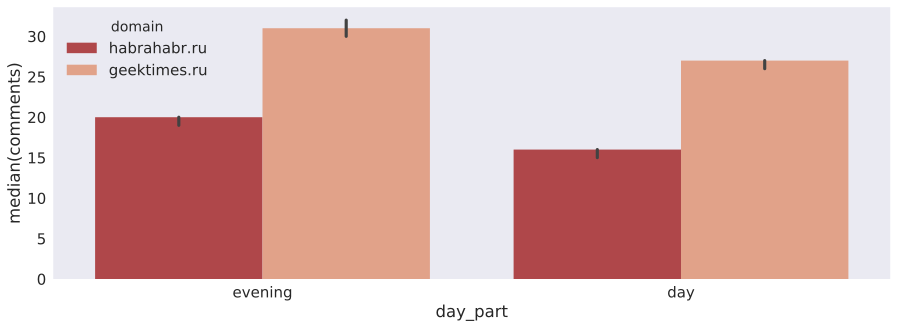

In [21]:
#df['day_part'] = df['hour'].map( lambda x: 'day' if (x > 10 & x <18) else if  (x >= 18 & x <24) 'evening' else'other')
#df['day_part'] = [round(d.hour/3)-1 for d in df.published]
#df['day_part'].head(10)
dy_nigth_df = df [(df.hour > 12) & (df.hour < 23)]
dy_nigth_df['day_part'] = dy_nigth_df.hour.map(lambda x: 'day' if x < 18 else 'evening')

sns.barplot(x="day_part", y="comments", hue='domain',data=dy_nigth_df, estimator=median);


## 4\. Кого из топ-20 авторов (по числу статей) чаще всего минусуют (в среднем)?

* @Mordatyj
* @Mithgol
* @alizar
* @ilya42

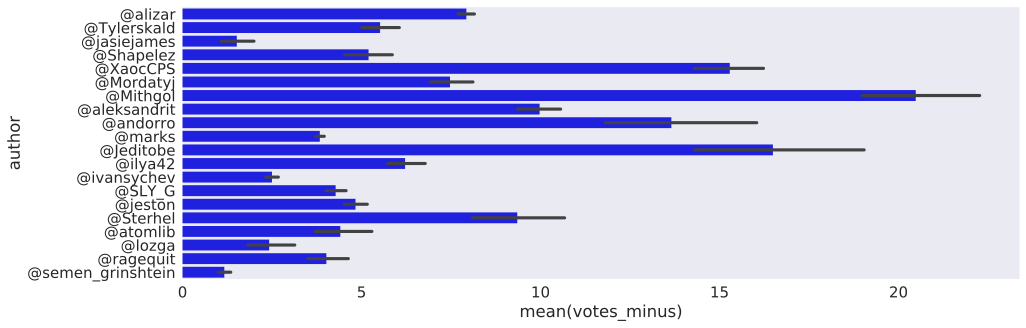

In [26]:
#df.author.value_counts().head(20)
#df[df.author.isin(df.author.value_counts().head(20))].shape
a = df.groupby('author').count().sort_values('url',ascending=False).head(20);

top20 = df[df.author.isin(a.index)]

sns.barplot(x="votes_minus", y="author", data=top20,
            label="Minus", color="b",estimator=mean);


#a.agg({'url' : 'count', 'votes_minus' : 'sum'}).sort_values('url',ascending=False).head(20).sort_values('votes_minus',ascending=False)

#plt.rcParams['figure.figsize'] = (20, 16)
#sns.countplot(x="education", data=data, palette="Greens_d");
#pd.groupby(df, ['author']).sum('votes_minus').count('post_id')
#for  in pd.groupby(data, ['author']):
#a.head(20)

#@Mithgol

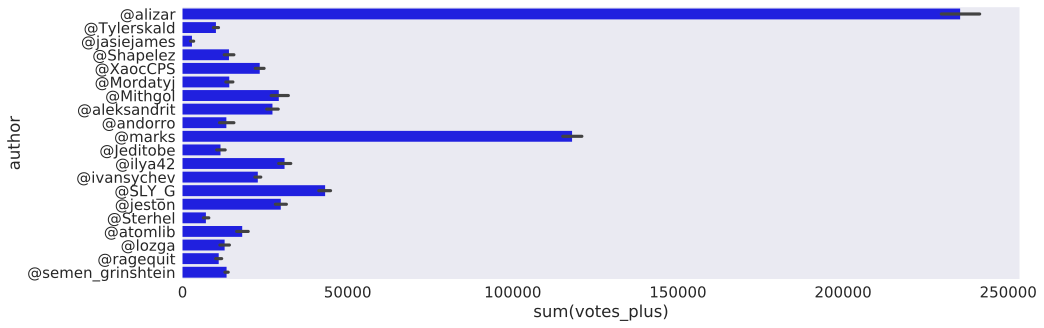

In [23]:
sns.barplot(x="votes_plus", y="author", data=top20,
            label="Plus", color="b",estimator=sum);

## 5\. Сравните субботы и понедельники

Правда ли, что по субботам авторы пишут в основном днём, а по понедельникам — в основном вечером?

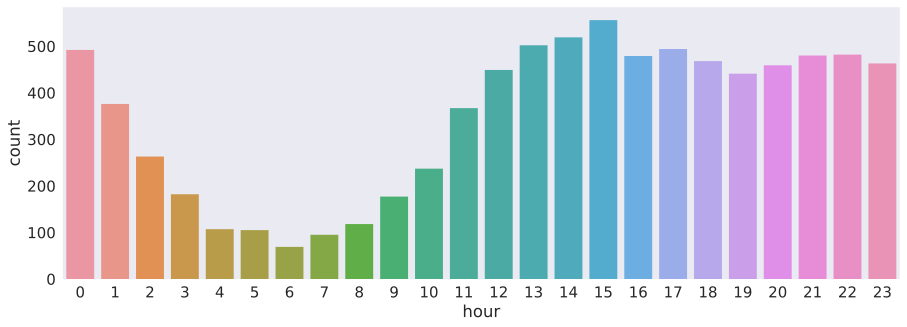

In [24]:
df_sat = df[df.dayofweek==6]
sns.countplot(x='hour', data=df_sat);

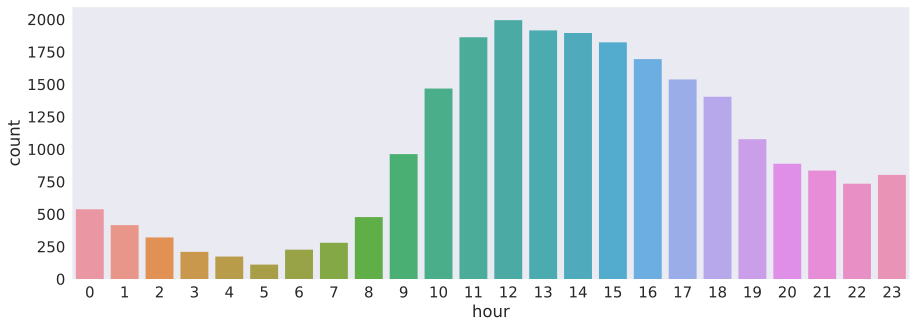

In [25]:
df_mon = df[df.dayofweek==1]
sns.countplot(x='hour', data=df_mon);